<a href="https://colab.research.google.com/github/Kkingssss/Brain-Tumor-Segmentation/blob/main/final_Brain_Tumor_SegResnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brain Tumor Segmentation with SegResNet**

---








Dataset and Json file can dowload here ! 
https://drive.google.com/drive/folders/1-MsS1-l2ENpYpWWfmQBiwT7aYMMpDy0D?usp=sharing

##**Setup environment**

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

##**Setup imports**

In [3]:
import os
import shutil
import tempfile
import json
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import nibabel as nib #for read .nii file
%pip install pytorch-ignite
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai import transforms  
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
)
from monai.utils import set_determinism
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 259 kB 9.6 MB/s 


##**Import from Google drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Change Directory**

In [5]:
%cd /content/drive/MyDrive/AI_builders

/content/drive/MyDrive/AI_builders


##**Setup data directory**

In [6]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpz7_0mzkp


##**Setup fold reader**

In [7]:
def datafold_read(datalist, basedir, fold=0, key="training"):

    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k, v in d.items():
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    train = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold: val.append(d)
        else: train.append(d)

    return  train, val

##**Setup dataloader**


In [8]:
def get_loader(batch_size, data_dir, json_list, fold, roi):
    data_dir = data_dir
    datalist_json = json_list
    train_files, validation_files = datafold_read(datalist=datalist_json, basedir=data_dir, fold=fold)
    
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
            ),
            transforms.RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[roi[0], roi[1], roi[2]],
                random_size=False,
            ),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            transforms.NormalizeIntensityd( keys="image", nonzero=True, channel_wise=True),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
            transforms.ToTensord(keys=["image", "label"]),
        ]
    )

    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.NormalizeIntensityd( keys="image", nonzero=True, channel_wise=True ),
            transforms.ToTensord(keys=["image", "label"]),
        ]
    )

    train_ds = data.Dataset(data=train_files, transform=train_transform)

    train_loader = data.DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=8,pin_memory=True)
    val_ds = data.Dataset(data=validation_files, transform=val_transform)
    val_loader = data.DataLoader(val_ds,batch_size=1,shuffle=False,num_workers=8, pin_memory=True)

    return train_loader, val_loader

##**Set dataset root directory and hyper-parameters**


In [9]:
data_dir =  "/content/drive/MyDrive/AI_builders"
json_list = "/content/drive/MyDrive/AI_builders/brats21_folds.json"
roi = (128, 128, 128)
batch_size = 1
sw_batch_size = 2
fold = 1
infer_overlap = 0.5
max_epochs = 50
val_every = 10
train_loader, val_loader = get_loader(batch_size, data_dir, json_list, fold, roi)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


##**Check data shape and visualize**

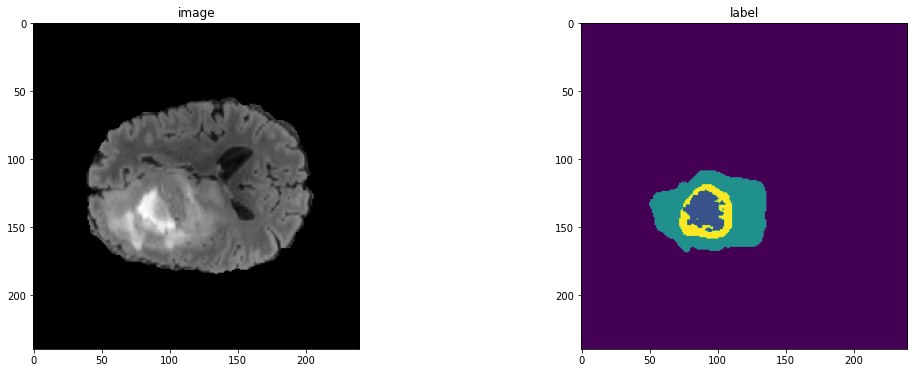

In [51]:
img_add = os.path.join(data_dir, "TrainingData/BraTS2021_00002/BraTS2021_00002_flair.nii.gz")
label_add = os.path.join( data_dir, "TrainingData/BraTS2021_00002/BraTS2021_00002_seg.nii.gz")

img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()

plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[:, :, 85], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 85])
plt.show()

##**Create Model, Loss, Optimizer**

In [14]:
max_epochs = 20
val_interval = 1
VAL_AMP = True
device = torch.device("cuda:0")

model = SegResNet(blocks_down=[1, 2, 2, 4], blocks_up=[1, 1, 1],init_filters=16,in_channels=4,out_channels=3, dropout_prob=0.2,).to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
def inference(input):

    def Compute(input):
        return sliding_window_inference( inputs=input, roi_size=(240, 240, 160), sw_batch_size=1, predictor=model, overlap=0.5 )

    if VAL_AMP:
        with torch.cuda.amp.autocast():return Compute(input)
    else: return Compute(input)

scaler = torch.cuda.amp.GradScaler()
torch.backends.cudnn.benchmark = True

##**training process**

In [15]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []
max_epochs = 20
val_interval = 1
total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_loader) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in val_loader:
                val_inputs, val_labels = (val_data["image"].to(device), val_data["label"].to(device))
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save( model.state_dict(),  os.path.join(root_dir, "best_metric_model.pth") )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/20


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
36/1001, train_loss: 1.0000, step time: 0.6230
37/1001, train_loss: 0.0787, step time: 0.6484
38/1001, train_loss: 0.3626, step time: 0.6540
39/1001, train_loss: 0.0500, step time: 0.6728
40/1001, train_loss: 0.7155, step time: 0.6913
41/1001, train_loss: 0.0472, step time: 0.6640
42/1001, train_loss: 0.2271, step time: 0.6607
43/1001, train_loss: 0.0530, step time: 0.6661
44/1001, train_loss: 0.0764, step time: 0.6804
45/1001, train_loss: 0.1641, step time: 0.6519
46/1001, train_loss: 0.0563, step time: 0.6524
47/1001, train_loss: 1.0000, step time: 0.6380
48/1001, train_loss: 0.1186, step time: 0.6516
49/1001, train_loss: 0.9664, step time: 0.6502
50/1001, train_loss: 0.3631, step time: 0.6529
51/1001, train_loss: 0.0340, step time: 0.6485
52/1001, train_loss: 0.0549, step time: 0.6447
53/1001, train_loss: 0.1300, step time: 0.6512
54/1001, train_loss: 0.4108, step time: 0.6479
55/1001, train_loss: 0.1556, step time: 0.6803
56/

In [16]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.8719 at epoch: 19, total time: 16652.683278799057.


##**Plot the loss and metric**

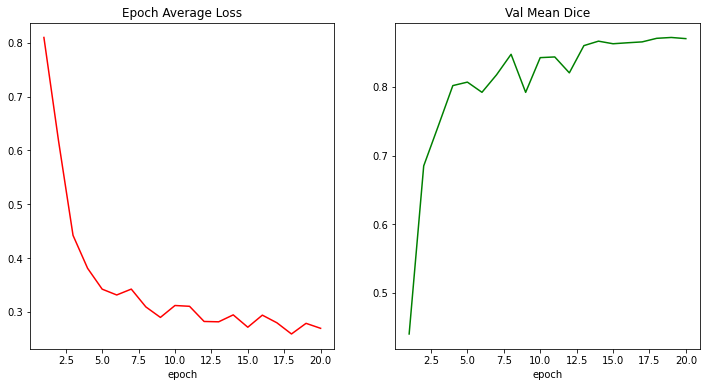

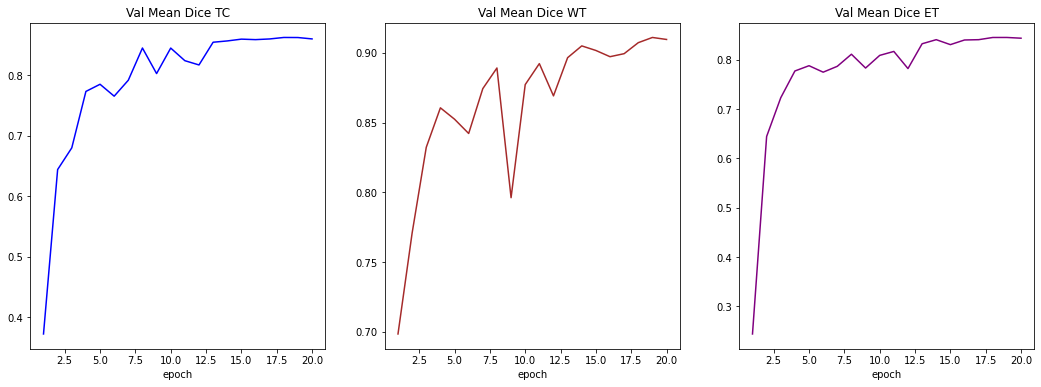

In [54]:

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")

plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")

plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")

plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

##**Create test set dataloader**

In [35]:
case_num = "01619"

test_files = [
    {
        "image": [
            os.path.join( data_dir, "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_flair.nii.gz" ),
            os.path.join( data_dir, "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz"  ),
            os.path.join( data_dir, "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1.nii.gz" ),
            os.path.join( data_dir, "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t2.nii.gz" ),
        ],
        "label": os.path.join( data_dir, "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num+ "_seg.nii.gz" ),
    }
]

test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        transforms.ToTensord(keys=["image", "label"]),
    ]
)

test_ds = data.Dataset(data=test_files, transform=test_transform)

test_loader = data.DataLoader( test_ds, batch_size=1, shuffle=False, num_workers=8, pin_memory=True )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


##**Load the best saved checkpoint and perform inference**

In [34]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.to(device)
model.eval()

model_inferer_test = partial( sliding_window_inference, roi_size=[roi[0], roi[1], roi[2]], sw_batch_size=1, predictor=model,overlap=0.6)

with torch.no_grad():
    for idx, batch_data in enumerate(test_loader):
        image = batch_data["image"].cuda()
        prob = torch.sigmoid(model_inferer_test(image))
        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        seg_out[seg[1] == 1] = 2
        seg_out[seg[0] == 1] = 1
        seg_out[seg[2] == 1] = 4

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


##**Visualize segmentation**

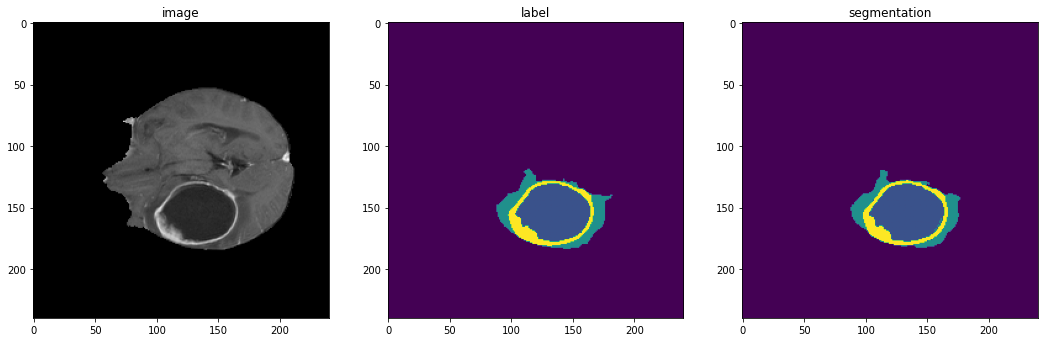

In [41]:
slice_num =60
img_add = os.path.join(data_dir,"TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz")
label_add = os.path.join(data_dir,"TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz")

img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
plt.imshow(seg_out[:, :, slice_num])
plt.show()